# Master1 - Empirical fMRI analyses, replication cohort

## Takuya Ito
#### 01/07/2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import nibabel as nib
import pandas as pd
import sys
sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import h5py
import dimensionality
sys.path.append('bctpy/')
import bct

## Set-up subject list and construct global variables

In [2]:
# ## Exploratory subjects
# subjNums = ['178950','189450','199453','209228','220721','298455','356948','419239','499566','561444','618952','680452','757764','841349','908860',
#             '103818','113922','121618','130619','137229','151829','158035','171633','179346','190031','200008','210112','221319','299154','361234',
#             '424939','500222','570243','622236','687163','769064','845458','911849','104416','114217','122317','130720','137532','151930','159744',
#             '172029','180230','191235','200614','211316','228434','300618','361941','432332','513130','571144','623844','692964','773257','857263',
#             '926862','105014','114419','122822','130821','137633','152427','160123','172938','180432','192035','200917','211417','239944','303119',
#             '365343','436239','513736','579665','638049','702133','774663','865363','930449','106521','114823','123521','130922','137936','152831',
#             '160729','173334','180533','192136','201111','211619','249947','305830','366042','436845','516742','580650','645450','715041','782561',
#             '871762','942658','106824','117021','123925','131823','138332','153025','162026','173536','180735','192439','201414','211821','251833',
#             '310621','371843','445543','519950','580751','647858','720337','800941','871964','955465','107018','117122','125222','132017','138837',
#             '153227','162329','173637','180937','193239','201818','211922','257542','314225','378857','454140','523032','585862','654350','725751',
#             '803240','872562','959574','107422','117324','125424','133827','142828','153631','164030','173940','182739','194140','202719','212015',
#             '257845','316633','381543','459453','525541','586460','654754','727553','812746','873968','966975']

## Validation subjects
subjNums = ['100206','108020','117930','126325','133928','143224','153934','164636','174437','183034','194443','204521','212823','268749','322224',
            '385450','463040','529953','587664','656253','731140','814548','877269','978578','100408','108222','118124','126426','134021','144832',
            '154229','164939','175338','185139','194645','204622','213017','268850','329844','389357','467351','530635','588565','657659','737960',
            '816653','878877','987074','101006','110007','118225','127933','134324','146331','154532','165638','175742','185341','195445','205119',
            '213421','274542','341834','393247','479762','545345','597869','664757','742549','820745','887373','989987','102311','111009','118831',
            '128632','135528','146432','154936','167036','176441','186141','196144','205725','213522','285345','342129','394956','480141','552241',
            '598568','671855','744553','826454','896879','990366','102513','112516','118932','129028','135629','146533','156031','167440','176845',
            '187850','196346','205826','214423','285446','348545','395756','481042','553344','599671','675661','749058','832651','899885','991267',
            '102614','112920','119126','129129','135932','147636','157336','168745','177645','188145','198350','208226','214726','286347','349244',
            '406432','486759','555651','604537','679568','749361','835657','901442','992774','103111','113316','120212','130013','136227','148133',
            '157437','169545','178748','188549','198451','208327','217429','290136','352738','414229','497865','559457','615744','679770','753150',
            '837560','907656','993675','103414','113619','120414','130114','136833','150726','157942','171330']

basedir = '/projects3/TaskFCMech/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

tasks = {'EMOTION':[0,1],
     'GAMBLING':[2,3],
     'LANGUAGE':[4,5],
     'MOTOR':[6,7,8,9,10,11],
     'RELATIONAL':[12,13],
     'SOCIAL':[14,15],
     'WM':[16,17,18,19,20,21,22,23]}
taskNames = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
TRsPerRun = [176,176,253,253,316,316,284,284,232,232,274,274,405,405]
restRuns = ['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR']
taskRuns= ['tfMRI_EMOTION_RL','tfMRI_EMOTION_LR','tfMRI_GAMBLING_RL','tfMRI_GAMBLING_LR',
           'tfMRI_LANGUAGE_RL','tfMRI_LANGUAGE_LR','tfMRI_MOTOR_RL','tfMRI_MOTOR_LR',
           'tfMRI_RELATIONAL_RL','tfMRI_RELATIONAL_LR','tfMRI_SOCIAL_RL','tfMRI_SOCIAL_LR','tfMRI_WM_RL','tfMRI_WM_LR']

# 0.0 Define functions for loading data

In [3]:
def loadRestResiduals(subj,model='24pXaCompCorXVolterra',zscore=False,FIR=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    data = []
    if FIR:
        dataid = 'rfMRI_REST_' + model + '_taskReg_resid_FIR'
        data = h5f['taskRegression'][dataid][:]
        if zscore:
            # Zscore each run separately
            runstart = 0
            for run in range(4):
                runend = runstart + 1195
                data[:,runstart:runend] = stats.zscore(data[:,runstart:runend],axis=1)
                runstart += 1195
                
            # Now z-score rest time series as if it were task
            trcount = 0
            for ntrs in TRsPerRun:
                trstart = trcount
                trend = trcount + ntrs
                data[:,trstart:trend] = stats.zscore(data[:,trstart:trend],axis=1)

                trcount += ntrs

        data = data.T
    else:
        for run in restRuns:
            dataid = run + '/nuisanceReg_resid_' + model
            tmp = h5f[dataid][:]
            tmp = stats.zscore(tmp,axis=1)
            data.extend(tmp.T)
    data = np.asarray(data).T
    h5f.close()
    return data

def loadTaskActivity(subj,model='24pXaCompCorXVolterra',zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    betas = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_betas_canonical'
        tmp = h5f['taskRegression'][dataid][:]
        betas.extend(tmp[:,1:].T)
    betas = np.asarray(betas).T
    h5f.close()
    return betas

def loadTaskResiduals(subj, model='24pXaCompCorXVolterra', taskModel='FIR', zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5'         
    h5f = h5py.File(datafile,'r')
    resids = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_resid_' + taskModel
        tmp = h5f['taskRegression'][dataid][:]
        if zscore:
            nTRsPerRun = tmp.shape[1]/2
            tmp[:,:nTRsPerRun] = stats.zscore(tmp[:,:nTRsPerRun],axis=1)
            tmp[:,nTRsPerRun:] = stats.zscore(tmp[:,nTRsPerRun:],axis=1)
        resids.extend(tmp.T)
    resids = np.asarray(resids).T
    h5f.close()
    return resids

### Main parameters

In [4]:
model = '24pXaCompCorXVolterra'
zscore = True
FIR = True

# 1.0 Identify number of significantly active regions for each task, relative to 0

## 1.1 First load task activation data

In [5]:
nTasks = 24
taskActivity = np.zeros((nParcels,nTasks,len(subjNums)))
scount = 0
for subj in subjNums:
    taskActivity[:,:,scount] = loadTaskActivity(subj, model=model, zscore=zscore)
    scount += 1

## 1.2 Perform t-test against 0 for each task condition

In [6]:
taskActivity_stats = np.zeros((nParcels,nTasks,3)) # t-stat, p-value, q-value
for task in range(nTasks):
    ts, ps = stats.ttest_1samp(taskActivity[:,task,:],0,axis=1)
#     i = 0
#     for t in ts:
#         ps[i] = ps[i]/2.0 if t>0 else 1.0-ps[i]/2.0
#         i += 1
    
    q = mc.fdrcorrection0(ps)[0]
    taskActivity_stats[:,task,0] = ts
    taskActivity_stats[:,task,1] = ps
    taskActivity_stats[:,task,2] = q
    
    num_sig = np.sum(q==1)
    print 'Condition', task+1, 'has', num_sig, 'significantly active regions'
    
# Compute the average activity across all tasks across all brain regions
taskAvg = np.mean(np.mean(taskActivity,axis=0),axis=0)

t, p = stats.ttest_1samp(taskAvg, 0)
print 'Average whole-brain activity across all tasks'
print '\tt =', t, '| p =', p
print 'DoF:', len(subjNums)-1

Condition 1 has 253 significantly active regions
Condition 2 has 258 significantly active regions
Condition 3 has 319 significantly active regions
Condition 4 has 320 significantly active regions
Condition 5 has 298 significantly active regions
Condition 6 has 317 significantly active regions
Condition 7 has 313 significantly active regions
Condition 8 has 229 significantly active regions
Condition 9 has 252 significantly active regions
Condition 10 has 267 significantly active regions
Condition 11 has 239 significantly active regions
Condition 12 has 266 significantly active regions
Condition 13 has 321 significantly active regions
Condition 14 has 309 significantly active regions
Condition 15 has 295 significantly active regions
Condition 16 has 299 significantly active regions
Condition 17 has 212 significantly active regions
Condition 18 has 230 significantly active regions
Condition 19 has 266 significantly active regions
Condition 20 has 285 significantly active regions
Condition

## Compare connectivity of activated regions for task relative to rest, for each condition

## Load rest and task data time series

In [7]:
nTasks = 24
restTS = np.zeros((nParcels,4780,len(subjNums)))
restTS = np.zeros((nParcels,3810,len(subjNums)))
taskTS = np.zeros((nParcels,3810,len(subjNums)))
task_timing = np.zeros((3810,nTasks,len(subjNums)))
scount = 0
for subj in subjNums:
    if scount%25==0: print 'Loading in data for subject', scount+1, '/', len(subjNums)
    restTS[:,:,scount] = loadRestResiduals(subj,model=model,zscore=zscore,FIR=FIR)
    taskTS[:,:,scount] = loadTaskResiduals(subj, model=model, taskModel='FIR', zscore=zscore) # We make this FIR since we only want to use FIR regressed task residuals for FC analysis
    task_timing[:,:,scount] = tgp.loadTaskTimingForAllTasks(subj,taskModel='canonical')['taskRegressors']>.5 # Only to obtain which time points to estimate FC with
    scount += 1
    
task_timing = task_timing.astype(bool)


Loading in data for subject 1 / 176
Loading in data for subject 26 / 176
Loading in data for subject 51 / 176
Loading in data for subject 76 / 176
Loading in data for subject 101 / 176
Loading in data for subject 126 / 176
Loading in data for subject 151 / 176
Loading in data for subject 176 / 176


## Compute task-general FC (across all task conditions versus rest FC)

In [8]:
taskGeneralFC = np.zeros((nParcels,nParcels,len(subjNums)))
restGeneralFC = np.zeros((nParcels,nParcels,len(subjNums)))
df_dimensionality = {}
df_dimensionality['State'] = []
df_dimensionality['Subject'] = []
df_dimensionality['Dimensionality'] = []

for s in range(len(subjNums)):
    taskGeneralTiming = np.sum(task_timing[:,:,s],axis=1)>0
#     taskGeneralTiming = task_timing[:,22,s]>0
    
    taskGeneralFC[:,:,s] = np.corrcoef(taskTS[:,taskGeneralTiming,s])
    np.fill_diagonal(taskGeneralFC[:,:,s],0)
    
    restGeneralFC[:,:,s] = np.corrcoef(restTS[:,taskGeneralTiming,s])
    np.fill_diagonal(restGeneralFC[:,:,s],0)
    
    df_dimensionality['State'].append('Task')
    df_dimensionality['Subject'].append(subjNums[s])
    tmp = np.cov(taskTS[:,taskGeneralTiming,s])
    df_dimensionality['Dimensionality'].append(dimensionality.getDimensionality(tmp))
    
    df_dimensionality['State'].append('Rest')
    df_dimensionality['Subject'].append(subjNums[s])
    tmp = np.cov(restTS[:,taskGeneralTiming,s])
    df_dimensionality['Dimensionality'].append(dimensionality.getDimensionality(tmp))
    

    
# Fz transform
taskGeneralFC = np.arctanh(taskGeneralFC)
restGeneralFC = np.arctanh(restGeneralFC)

groupStatsFC = np.zeros((nParcels,nParcels,3))
groupStatsFC[:,:,0], groupStatsFC[:,:,1] = stats.ttest_rel(taskGeneralFC,restGeneralFC,axis=2)

# FDR-correction
triu_ind = np.triu_indices(nParcels,k=1)
groupStatsFC[:,:,2][triu_ind] = mc.fdrcorrection0(groupStatsFC[:,:,1][triu_ind])[0]
groupStatsFC[:,:,2] = groupStatsFC[:,:,2] + groupStatsFC[:,:,2].T
np.fill_diagonal(groupStatsFC[:,:,1],1) # diagonal p-value should be

/usr/local/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Compute dimensionality for task FC and rest FC separately (for each subject)

Task versus rest, global dimensionality
	 Dim diff = 15.7750053145
	 t = 21.6567692066 | p = 2.16339904649e-51


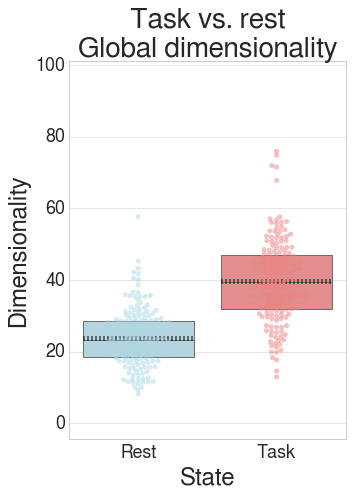

In [9]:
# df_dimensionality = {}
# df_dimensionality['State'] = []
# df_dimensionality['Subject'] = []
# df_dimensionality['Dimensionality'] = []
# scount = 0
# for subj in subjNums:
#     df_dimensionality['State'].append('Task')
#     df_dimensionality['Subject'].append(subj)
#     tmp = taskGeneralFC[:,:,scount].copy()
#     np.fill_diagonal(tmp,1)
#     df_dimensionality['Dimensionality'].append(dimensionality.getDimensionality(tmp))
    
#     df_dimensionality['State'].append('Rest')
#     df_dimensionality['Subject'].append(subj)
#     tmp = restGeneralFC[:,:,scount].copy()
#     np.fill_diagonal(tmp,1)
#     df_dimensionality['Dimensionality'].append(dimensionality.getDimensionality(tmp))
    
#     scount += 1
    
df_dimensionality = pd.DataFrame(df_dimensionality)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
tmprest = df_dimensionality.loc[df_dimensionality['State']=='Rest']
tmptask = df_dimensionality.loc[df_dimensionality['State']=='Task']
t, p = stats.ttest_rel(tmptask['Dimensionality'],tmprest['Dimensionality'])

sns.boxplot(data=[tmprest['Dimensionality'],tmptask['Dimensionality']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[tmprest['Dimensionality'],tmptask['Dimensionality']],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
# if str(round(p,3))=="0.0": 
#     p = '$p < 0.0001$'
# else:
#     p = '$p = ' + str(round(p,3))
plt.title('Task vs. rest\nGlobal dimensionality',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Dimensionality',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.ylim([np.min(df_dimensionality['Dimensionality'])-np.std(df_dimensionality['Dimensionality']),np.max(df_dimensionality['Dimensionality'])+2*np.std(df_dimensionality['Dimensionality'])]);
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('fMRI1s_GlobalDimensionality_Replication.pdf')

print 'Task versus rest, global dimensionality'
print '\t Dim diff =', np.mean(tmptask['Dimensionality']) - np.mean(tmprest['Dimensionality'])
print '\t t =', t, '| p =', p


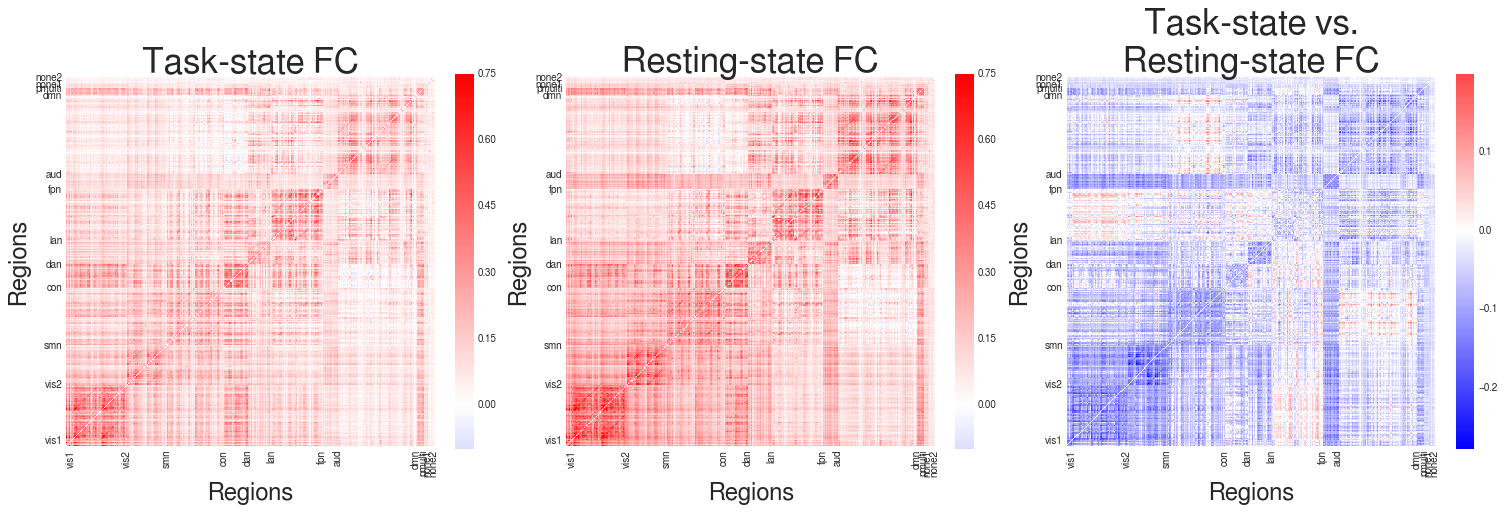

In [10]:
plt.figure(figsize=(21,7))
plt.subplot(131)
tmptask = np.tanh(np.mean(taskGeneralFC,axis=2))
# sigFC = np.multiply(rest[:,:,0],groupStatsFC[:,:,2])
ax = sns.heatmap(tmptask[networkorder,networkorder.T],square=True,center=0, vmin=-.1, vmax=.75, cmap='bwr',cbar=True,cbar_kws={'fraction':0.046})
plt.xticks(xticks.keys(),xticks.values());
plt.yticks(xticks.keys(),xticks.values());
plt.xlabel('Regions',fontsize=24)
plt.ylabel('Regions',fontsize=24)
plt.title('Task-state FC',fontsize=35)
ax.invert_yaxis()
# print np.sum(sigFC)


plt.subplot(132)
tmprest = np.tanh(np.mean(restGeneralFC,axis=2))
# sigFC = np.multiply(rest[:,:,0],groupStatsFC[:,:,2])
ax = sns.heatmap(tmprest[networkorder,networkorder.T],square=True,center=0,cmap='bwr',vmin=-.1, vmax=.75, cbar=True,cbar_kws={'fraction':0.046})
plt.xticks(xticks.keys(),xticks.values());
plt.yticks(xticks.keys(),xticks.values());
plt.xlabel('Regions',fontsize=24)
plt.ylabel('Regions',fontsize=24)
plt.title('Resting-state FC',fontsize=35)
ax.invert_yaxis()

plt.subplot(133)
# sigFC = np.multiply(groupStatsFC[:,:,0],groupStatsFC[:,:,2])
sigFC = np.multiply(tmptask-tmprest,groupStatsFC[:,:,2])
ax = sns.heatmap(sigFC[networkorder,networkorder.T],square=True,center=0,cmap='bwr', cbar=True,cbar_kws={'fraction':0.046})
plt.xticks(xticks.keys(),xticks.values());
plt.yticks(xticks.keys(),xticks.values());
plt.xlabel('Regions',fontsize=24)
plt.ylabel('Regions',fontsize=24)
plt.title('Task-state vs.\nResting-state FC',fontsize=35)
ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('fMRI1s_TaskRestFC_Replication.pdf')



	Number of FC Increases: 9.07149489322
	Number of FC Decreases: 78.1290622098


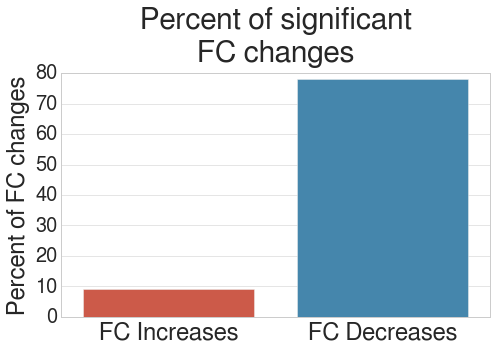

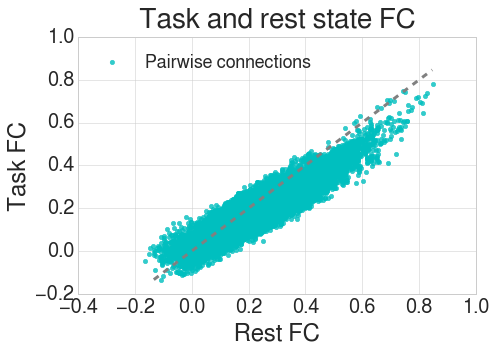

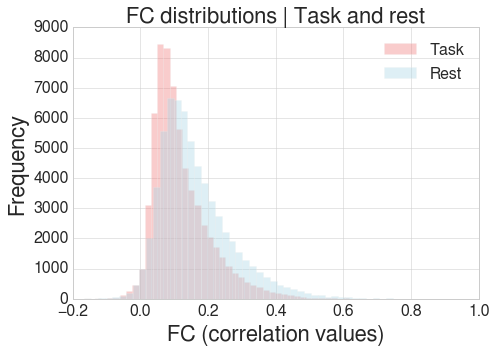

In [14]:
totalConn = (nParcels*nParcels)-nParcels
posFC = np.sum(np.multiply(groupStatsFC[:,:,0]>0,groupStatsFC[:,:,2]))/totalConn*100
negFC = np.sum(np.multiply(groupStatsFC[:,:,0]<0,groupStatsFC[:,:,2]))/totalConn*100

print '\tNumber of FC Increases:', posFC
print '\tNumber of FC Decreases:', negFC
# print '\tPos-Neg Ratio =', posFC/negFC

plt.figure(figsize=(7,5))
sns.barplot(x=np.arange(2),y=[posFC,negFC])
plt.xticks(np.arange(2),['FC Increases', 'FC Decreases'],fontsize=24)
plt.ylabel('Percent of FC changes',fontsize=24)
plt.yticks(fontsize=20)
plt.title('Percent of significant\nFC changes', y=1.03,fontsize=30)
plt.tight_layout()
# plt.savefig('fMRI1s_NumberFCChanges_Replication.pdf')

## Reviewer request - scatter plot of connection-wise FC changes
triu_ind = np.triu_indices(nParcels,k=1)
plt.figure(figsize=(7,5))
df = {}
df['Rest FC'] = []
df['Task FC'] = []
df['Rest FC'].extend(np.tanh(np.mean(restGeneralFC,axis=2))[triu_ind])
df['Task FC'].extend(np.tanh(np.mean(taskGeneralFC,axis=2))[triu_ind])
df = pd.DataFrame(data=df)
sns.regplot(x="Rest FC",y="Task FC",data=df,fit_reg=False,label='Pairwise connections',color='c')
minfc = np.min(np.tanh(np.mean(taskGeneralFC,axis=2))[triu_ind])
maxfc = np.max(np.tanh(np.mean(restGeneralFC,axis=2))[triu_ind])
plt.plot(np.arange(minfc,maxfc,0.005),np.arange(minfc,maxfc,0.005),color='grey',linestyle='--',linewidth=3)
plt.title('Task and rest state FC',fontsize=28, y=1.02)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Task FC', fontsize=24)
plt.xlabel('Rest FC', fontsize=24)
plt.legend(loc=2, prop={'size': 18})
plt.tight_layout()
plt.savefig('fMRI1s_TaskRestFC_Change_Scatter.jpg',dpi=300)


## Reviewer request - plot distributions of FC changes task v rest
plt.figure(figsize=(7,5))
plt.title('FC distributions | Task and rest',fontsize=22)
sns.distplot(np.tanh(np.mean(taskGeneralFC,axis=2))[triu_ind],bins=50,kde=False,label='Task',color='#f08080')
sns.distplot(np.tanh(np.mean(restGeneralFC,axis=2))[triu_ind],bins=50,kde=False,label='Rest',color='#add8e6')
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('FC (correlation values)',fontsize=22);
plt.ylabel('Frequency',fontsize=22);
plt.legend(prop={'size': 16})
plt.tight_layout()
# plt.savefig('fMRI1s_TaskRestFC_Change_Distribution.jpg',dpi=300)

Rank Correlation between co-activation map and FC difference map
	Rho = -0.0610634081185
	p = 1.95503233606e-54


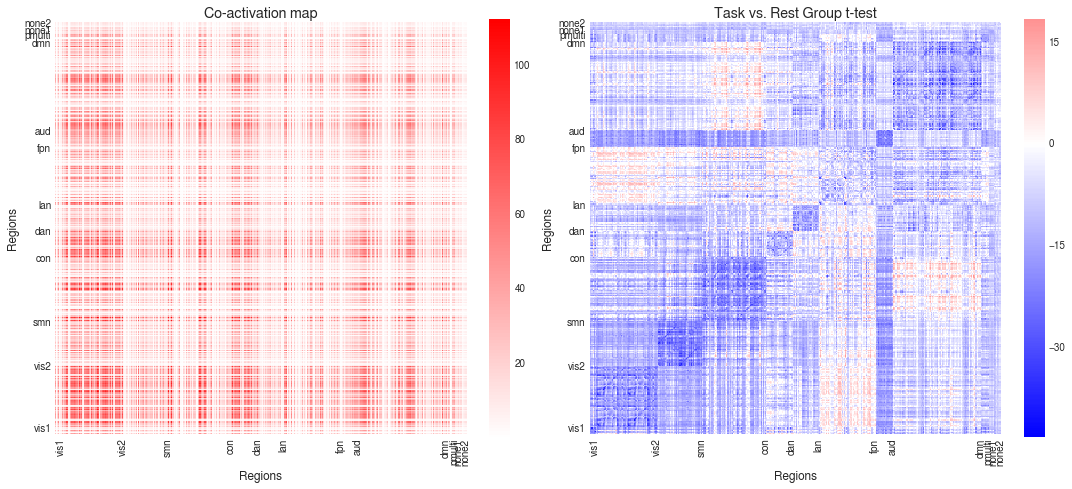

In [16]:
plt.figure(figsize=(15,7))
plt.subplot(121)
activity = np.mean(taskActivity,axis=1)
t, p = stats.ttest_1samp(activity,0,axis=1)
qs = mc.fdrcorrection0(p)[0]
tsig = np.multiply(t,qs)
tsig = t
tsig.shape = (len(tsig),1)
# tsig = np.corrcoef(tsig)
tsig = np.dot(tsig,tsig.T)/np.std(tsig)**2

activity = stats.ttest_1samp(taskActivity,0,axis=2)[0]
coactivation = np.abs(np.mean(activity,axis=1))
coactivation.shape = (len(coactivation),1)
coactivation = np.dot(coactivation,coactivation.T)
tsig = coactivation

ax = sns.heatmap(tsig[networkorder,networkorder.T],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.title('Significantly active regions\nCross-task average')
plt.ylabel('Regions')
ax.invert_yaxis()
plt.title('Co-activation map')
plt.xticks(xticks.keys(),xticks.values());
plt.yticks(xticks.keys(),xticks.values());
plt.xlabel('Regions')
plt.ylabel('Regions')

plt.subplot(122)
sigFC = np.multiply(groupStatsFC[:,:,0],groupStatsFC[:,:,2])
ax = sns.heatmap(sigFC[networkorder,networkorder.T],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(xticks.keys(),xticks.values());
plt.yticks(xticks.keys(),xticks.values());
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.title('Task vs. Rest Group t-test')
ax.invert_yaxis()
plt.tight_layout()

# Now correlate co-activation map with task-v rest map
activity = stats.ttest_1samp(taskActivity,0,axis=2)[0]
coactivation = np.abs(np.mean(activity,axis=1))
coactivation.shape = (len(coactivation),1)
coactivation = np.dot(coactivation,coactivation.T)
# coactivation = np.corrcoef(coactivation)
# t, p = stats.ttest_1samp(activity,0,axis=1)
triu_ind = np.triu_indices(nParcels,k=1)
r, p = stats.spearmanr(coactivation[triu_ind],groupStatsFC[:,:,0][triu_ind])
print 'Rank Correlation between co-activation map and FC difference map'
print '\tRho =', r
print '\tp =', p


In [17]:
nproc = 20
# taskRestFCDiff = np.zeros((nParcels,len(tasks),3)) # t-stat, p-value, q-value
# taskFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
# restFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings
# FC_change_stats = np.zeros((nParcels,nParcels,len(tasks),3)) # p and q values

# taskSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
# restSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings

# nCond = 24

taskRestFCDiff = np.zeros((nParcels,len(tasks),3)) # t-stat, p-value, q-value
taskFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
restFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings
FC_change_stats = np.zeros((nParcels,nParcels,len(tasks),3)) # p and q values

taskSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
restSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings

def computeFC(data):
    fc = np.corrcoef(data)
    np.fill_diagonal(fc,0)
    fc = np.arctanh(fc)
    return fc

task = 0
for t in taskNames:
    task_ind = tasks[t]
    
    inputsRest = []
    inputsTask = []
    scount = 0
    for subj in subjNums:
        tasktime = np.sum(task_timing[:,task_ind,scount],axis=1)>0 # isolate task
#         tasktime = task_timing[:,task,scount] # isolate task
        
        
#         taskSD[:,task,scount] = np.std(taskTS[:,tasktime,scount],axis=1)
#         restSD[:,task,scount] = np.std(restTS[:,tasktime,scount],axis=1)
#         taskmean = np.mean(taskTS[:,tasktime,scount],axis=1)
#         taskmean.shape = (len(taskmean),1)
#         restmean = np.mean(restTS[:,tasktime,scount],axis=1)
#         restmean.shape = (len(restmean),1)
#         taskSD[:,task,scount] = np.mean((taskTS[:,tasktime,scount]-taskmean)**2,axis=1)
#         restSD[:,task,scount] = np.mean((restTS[:,tasktime,scount]-restmean)**2,axis=1)
        
        taskSD[:,task,scount] = np.var(taskTS[:,tasktime,scount],axis=1)
        restSD[:,task,scount] = np.var(restTS[:,tasktime,scount],axis=1)
        # Fano factor
#         taskSD[:,task,scount] = np.divide(np.std(taskTS[:,tasktime,scount],axis=1)**2,np.mean(taskActivity[:,task_ind,scount],axis=1))
#         restSD[:,task,scount] = np.divide(np.std(restTS[:,tasktime,scount],axis=1)**2,np.mean(taskActivity[:,task_ind,scount],axis=1))
        
        inputsRest.append(restTS[:,tasktime,scount])
        inputsTask.append(taskTS[:,tasktime,scount])
        
        scount += 1
        
    pool = mp.Pool(processes=nproc)
    resultsRest = pool.map_async(computeFC,inputsRest).get()
    pool.close()
    pool.join()
    
    pool = mp.Pool(processes=nproc)
    resultsTask = pool.map_async(computeFC,inputsTask).get()
    pool.close()
    pool.join()
    
    for s in range(len(subjNums)):
        restFC[:,:,task,s] = resultsRest[s]
        taskFC[:,:,task,s] = resultsTask[s]
    
    t, p = stats.ttest_rel(taskFC[:,:,task,:], restFC[:,:,task,:],axis=2)
    FC_change_stats[:,:,task,0] = np.tanh(np.mean(taskFC[:,:,task,:] - restFC[:,:,task,:],axis=2))
    FC_change_stats[:,:,task,1] = p
    np.fill_diagonal(FC_change_stats[:,:,task,1],1.0) # diagonal should have p=1.0
    
    # Perform FDR-correction on changed connections
    triu_ind = np.triu_indices(nParcels,k=1)
    FC_change_stats[:,:,task,2][triu_ind] = mc.fdrcorrection0(FC_change_stats[:,:,task,1][triu_ind])[0]
    FC_change_stats[:,:,task,2] = FC_change_stats[:,:,task,2] + FC_change_stats[:,:,task,2].T
    np.fill_diagonal(FC_change_stats[:,:,task,2],0) # Diagonal should have q=1.0
    
    task += 1
        

# 1.0 *Hypothesis*: From rest to task states, there will be more quenching of correlated variability (and overall variability)

#### Group-averaged analysis (using average difference across tasks)

Average correlation difference between task versus rest: -0.0461456164169
Task vs. Rest average FC difference: t = -13.995692166 | p = 2.36714145934e-30
Average SD difference between task versus rest: -0.0191092708457
Task vs. Rest average SD difference: t = -20.7185614025 | p = 5.77932137335e-49
Task block v inter-block interval: t = -33.0088326068 | p = 4.5413722103e-77 | sd-1 = -0.017782798159


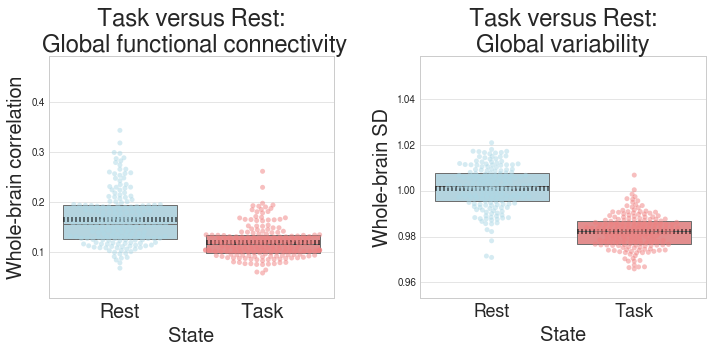

In [18]:
# Perform a Group-level analysis; average across all tasks
taskfc_avg = np.mean(np.mean(np.mean(taskFC,axis=2),axis=1),axis=0) # Compute average correlation for each subject
restfc_avg = np.mean(np.mean(np.mean(restFC,axis=2),axis=1),axis=0)
fcstats = np.zeros((3,)) # avg r, t, p
fcstats[0] = np.mean(taskfc_avg-restfc_avg)
fcstats[1],fcstats[2] = stats.ttest_rel(taskfc_avg,restfc_avg)
print 'Average correlation difference between task versus rest:', fcstats[0]
print 'Task vs. Rest average FC difference: t =', fcstats[1], '| p =', fcstats[2]

taskSD_avg = np.mean(np.mean(taskSD,axis=1),axis=0)
restSD_avg = np.mean(np.mean(restSD,axis=1),axis=0)
# taskSD_avg = np.mean(taskSD,axis=0)
# restSD_avg = np.mean(restSD,axis=0)
sdstats = np.zeros((3,))
sdstats[0] = np.mean(taskSD_avg-restSD_avg)
sdstats[1],sdstats[2] = stats.ttest_rel(taskSD_avg,restSD_avg)
print 'Average SD difference between task versus rest:', sdstats[0]
print 'Task vs. Rest average SD difference: t =', sdstats[1], '| p =', sdstats[2]

## Compute SD of task blocks relative to inter-block intervals by comparing SD change relative to 1
tmp_t, tmp_p = stats.ttest_1samp(np.mean(np.mean(taskSD,axis=0),axis=0),1)
print 'Task block v inter-block interval: t =', tmp_t, '| p =', tmp_p, '| sd-1 =', np.mean(taskSD)-1.0

## Plot
df_stat = {}
df_stat['Subject'] = []
df_stat['FC'] = []
df_stat['SD'] = []
df_stat['State'] = []

# For rest state
df_stat['State'].extend(np.repeat('Rest',len(subjNums)))
df_stat['Subject'].extend(subjNums)
df_stat['FC'].extend(restfc_avg)
df_stat['SD'].extend(restSD_avg)
# For task state
df_stat['State'].extend(np.repeat('Task',len(subjNums)))
df_stat['Subject'].extend(subjNums)
df_stat['FC'].extend(taskfc_avg)
df_stat['SD'].extend(taskSD_avg)


df_stat = pd.DataFrame(df_stat)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Task versus Rest:\n Global functional connectivity',fontname='FreeSans',fontsize=24)
sns.boxplot(x="State",y="FC",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="FC",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain correlation',fontsize=20, fontname='FreeSans')
plt.xlabel('State', fontsize=20,fontname='FreeSans')
plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
plt.xticks(fontsize=20,fontname='FreeSans')

plt.subplot(122)
plt.title('Task versus Rest:\nGlobal variability',fontname='FreeSans',fontsize=24)
sns.boxplot(x="State",y="SD",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="SD",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain SD',fontsize=20, fontname='FreeSans')
plt.xlabel('State', fontsize=20,fontname='FreeSans')
plt.xticks(fontsize=18,fontname='FreeSans')
plt.ylim([np.min(df_stat['SD'])-np.std(df_stat['SD']),np.max(df_stat['SD'])+3*np.std(df_stat['SD'])]);
plt.tight_layout()
# plt.savefig('fMRI1s_WholeBrainFCandSD_TaskVRest_Replication.pdf')

## Compute the GBC and variability of each region during task versus rest, and visualize on the surface

In [19]:
fcByROI = np.zeros((glasser2.shape[0],4)) # fc diff, t, p, q
sdByROI = np.zeros((glasser2.shape[0],4)) # sd diff, t, p, q
actByROI = np.zeros((glasser2.shape[0],4)) # act diff, t, p, q
fcdiff = taskFC - restFC
sddiff = taskSD - restSD

ps_fc = []
ps_sd = []
ps_act = []

for roi in range(nParcels):
    roi_ind = np.where(glasser2==roi+1)[0]

    tmp = np.mean(np.mean(fcdiff[roi,:,:,:],axis=1),axis=1)
    t, p = stats.ttest_1samp(tmp,0)
    fcByROI[roi_ind,0] = np.mean(tmp)
    fcByROI[roi_ind,1] = t
    fcByROI[roi_ind,2] = p
    ps_fc.append(p)
    
    tmp = np.mean(sddiff[roi,:,:],axis=0)
    t, p = stats.ttest_1samp(tmp,0)
    sdByROI[roi_ind,0] = np.mean(tmp)
    sdByROI[roi_ind,1] = t
    sdByROI[roi_ind,2] = p
    ps_sd.append(p)
    
    tmp = np.mean(taskActivity[roi,:,:],axis=0)
    t, p = stats.ttest_1samp(tmp,0)
    actByROI[roi_ind,0] = np.mean(tmp)
    actByROI[roi_ind,1] = t
    actByROI[roi_ind,2] = p
    ps_act.append(p)
    
qs_fc = mc.fdrcorrection0(ps_fc)[1]
qs_sd = mc.fdrcorrection0(ps_sd)[1]
qs_act = mc.fdrcorrection0(ps_act)[1]

for roi in range(nParcels):
    roi_ind = np.where(glasser2==roi+1)[0]
    
    fcByROI[roi_ind,3] = qs_fc[roi]
    tmp = qs_fc[roi] < 0.05
    fcByROI[roi_ind,0] = np.multiply(fcByROI[roi_ind,0],tmp)
    fcByROI[roi_ind,1] = np.multiply(fcByROI[roi_ind,1],tmp)
    
    sdByROI[roi_ind,3] = qs_sd[roi]
    tmp = qs_sd[roi] < 0.05
    sdByROI[roi_ind,0] = np.multiply(sdByROI[roi_ind,0],tmp)
    sdByROI[roi_ind,1] = np.multiply(sdByROI[roi_ind,1],tmp)
    
    actByROI[roi_ind,3] = qs_act[roi]
    tmp = qs_act[roi] < 0.05
    actByROI[roi_ind,0] = np.multiply(actByROI[roi_ind,0],tmp)
    actByROI[roi_ind,1] = np.multiply(actByROI[roi_ind,1],tmp)
    
# # Compute effect size baseline (information content)
# outdir = '/projects3/TaskFCMech/data/results/fMRI_FC_SD_Glasser/'
# filename = 'TaskVRest_FC_64k_REPLICATION_' + model
# np.savetxt(outdir + filename + '.csv', fcByROI,fmt='%s')
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
# os.system(wb_command)

# # Compute effect size baseline (information content)
# outdir = '/projects3/TaskFCMech/data/results/fMRI_FC_SD_Glasser/'
# filename = 'TaskVRest_SD_64k_REPLICATION_' + model
# np.savetxt(outdir + filename + '.csv', sdByROI,fmt='%s')
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
# os.system(wb_command)

# # Compute effect size baseline (information content)
# outdir = '/projects3/TaskFCMech/data/results/fMRI_FC_SD_Glasser/'
# filename = 'TaskVRest_Activity_64k_REPLICATION_' + model
# np.savetxt(outdir + filename + '.csv', actByROI,fmt='%s')
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
# os.system(wb_command)

	Percent of FC Increases: 1.66666666667
	Number of FC Decreases: 81.1111111111
	Pos-Neg Ratio = 0.0205479452055


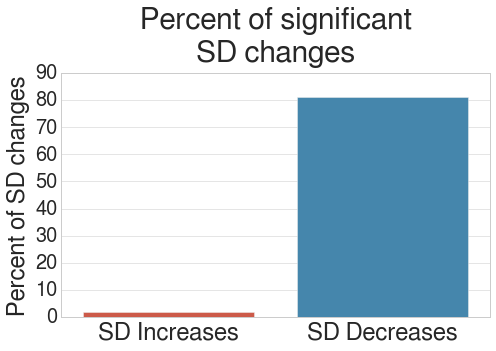

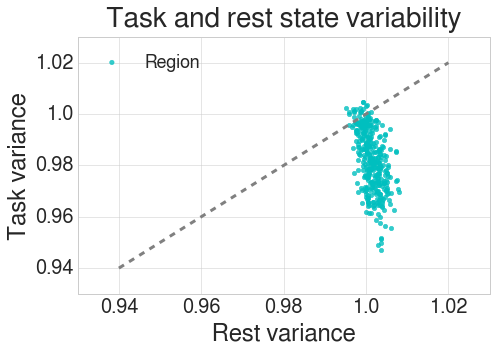

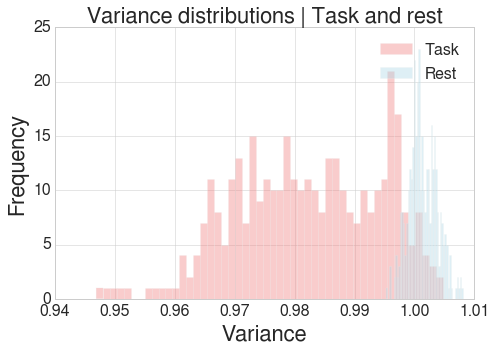

In [21]:
tmp = np.mean(np.mean(sddiff[:,:,:],axis=1),axis=1)
posSD = np.sum(np.multiply(tmp>0,qs_sd<0.05))/float(nParcels)*100
negSD = np.sum(np.multiply(tmp<0,qs_sd<0.05))/float(nParcels)*100


print '\tPercent of FC Increases:', posSD
print '\tNumber of FC Decreases:', negSD
print '\tPos-Neg Ratio =', posSD/negSD

plt.figure(figsize=(7,5))
sns.barplot(x=np.arange(2),y=[posSD,negSD])
plt.xticks(np.arange(2),['SD Increases', 'SD Decreases'],fontsize=24)
plt.ylabel('Percent of SD changes',fontsize=24)
plt.yticks(fontsize=20)
plt.title('Percent of significant\nSD changes', y=1.03,fontsize=30)
plt.tight_layout()
# plt.savefig('fMRI1s_NumberSDChanges_Replication.pdf')

## Reviewer request - scatter plot of connection-wise FC changes
triu_ind = np.triu_indices(nParcels,k=1)
plt.figure(figsize=(7,5))
df = {}
df['Rest'] = []
df['Task'] = []
df['Rest'].extend(np.mean(np.mean(restSD,axis=1),axis=1))
df['Task'].extend(np.mean(np.mean(taskSD,axis=1),axis=1))
df = pd.DataFrame(data=df)
sns.regplot(x="Rest",y="Task",data=df,fit_reg=False,label='Region',color='c')
plt.plot(np.arange(0.94,1.02,0.001),np.arange(0.94,1.02,0.001),color='grey',linestyle='--',linewidth=3)
plt.title('Task and rest state variability',fontsize=28, y=1.02)
plt.xticks(np.arange(0.94,1.02,0.02),np.arange(0.94,1.02,0.02),fontsize=20)
plt.yticks(np.arange(0.94,1.02,0.02),np.arange(0.94,1.02,0.02),fontsize=20)
plt.ylabel('Task variance', fontsize=24)
plt.xlabel('Rest variance', fontsize=24)
plt.legend(loc=2, prop={'size': 18})
plt.tight_layout()
plt.savefig('fMRI1s_TaskRestVar_Change_Scatter.jpg',dpi=300)


## Reviewer request - plot distributions of FC changes task v rest
plt.figure(figsize=(7,5))
plt.title('Variance distributions | Task and rest',fontsize=22)
sns.distplot(np.mean(np.mean(taskSD,axis=1),axis=1),bins=50,kde=False,label='Task',color='#f08080')
sns.distplot(np.mean(np.mean(restSD,axis=1),axis=1),bins=50,kde=False,label='Rest',color='#add8e6')
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('Variance',fontsize=22);
plt.ylabel('Frequency',fontsize=22);
plt.legend(prop={'size': 16})
plt.tight_layout()
# plt.savefig('fMRI1s_TaskRestVar_Change_Distribution.jpg',dpi=300)


# Correlate if regions with more evoked activity are associated with more decreases in FC/variability (at group-level)

## Correlate task activity with SD reduction across regions
##### This is a replication of He et al. (2013)

SpearmanrResult(correlation=-0.49027384470559177, pvalue=3.617932952867784e-23)
SD Reduction: -0.01910927084568976
Activity-level: 0.793525171710489


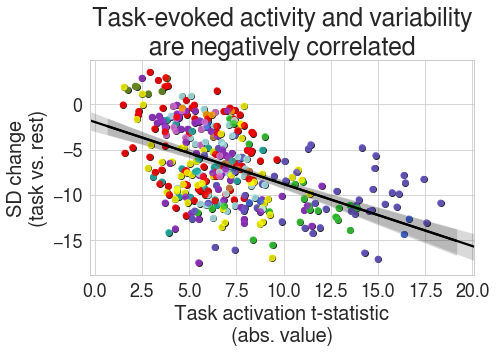

In [37]:
tmp_sddiff = np.zeros((360,2))
tmp_act = np.zeros((360,2))
for roi in range(360):
    tmp = np.mean(taskSD[roi,:,:],axis=0) - np.mean(restSD[roi,:,:],axis=0)
#     tmp = stats.ttest_rel(taskSD[roi,:,:], restSD[roi,:,:],axis=1)[0]
    t, p = stats.ttest_1samp(tmp,0)
    tmp_sddiff[roi,0] = np.mean(tmp)
    tmp_sddiff[roi,1] = t
    
    t = np.mean(np.abs(stats.ttest_1samp(taskActivity[roi,:,:],0,axis=1)[0]))
    tmp_act[roi,0] = np.mean(taskActivity[roi,:,:])
    tmp_act[roi,1] = t

print stats.spearmanr(tmp_sddiff[:,0],tmp_act[:,1])
print 'SD Reduction:', np.mean(tmp_sddiff[:,0],axis=0)
print 'Activity-level:', np.mean(tmp_act[:,0],axis=0)

networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
tmp = {}
netcount = 0
for network in orderednetworks:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        tmp[roi] = networkpalette[netcount]
    netcount += 1

roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    

plt.figure(figsize=(7,5))
sns.regplot(tmp_act[:,1],tmp_sddiff[:,1],color='k')
sns.regplot(tmp_act[:,1],tmp_sddiff[:,1],color='k',scatter_kws={'color':roiColorsByNetwork})
plt.xlabel('Task activation t-statistic\n(abs. value)',fontsize=20)
plt.ylabel('SD change\n(task vs. rest)',fontsize=20)
plt.title('Task-evoked activity and variability\nare negatively correlated',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('fMRI1s_ActivityXSD_RegionalCorrelation_Replication.pdf')

# Correlation

SpearmanrResult(correlation=-0.19736031913826496, pvalue=0.00016406085469088317)
FC Reduction: -0.046145616416944986
Activity-level: 0.793525171710489


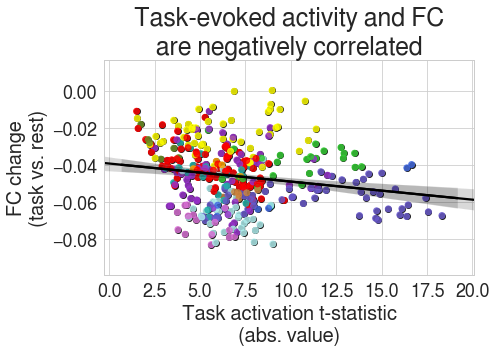

In [38]:
tmp_fcdiff = np.zeros((360,2))
tmp_act = np.zeros((360,2))
for roi in range(360):
    tmp = np.mean(np.mean(taskFC[roi,:,:,:],axis=1),axis=0) - np.mean(np.mean(restFC[roi,:,:,:],axis=1),axis=0)
#     tmp = stats.ttest_1samp(taskGeneralFC[roi,:,:],0,axis=0)[0] - stats.ttest_1samp(restGeneralFC[roi,:,:],0,axis=0)[0]
#     tmp = stats.ttest_rel(tmp[roi,:,:],0-,axis=0)[0] 
    
    t, p = stats.ttest_1samp(tmp,0)
    tmp_fcdiff[roi,0] = np.mean(tmp)
    tmp_fcdiff[roi,1] = t
    
    t = np.mean(np.abs(stats.ttest_1samp(taskActivity[roi,:,:],0,axis=1)[0]))
    tmp_act[roi,0] = np.mean(taskActivity[roi,:,:])
    tmp_act[roi,1] = t
    
print stats.spearmanr(tmp_fcdiff[:,0],tmp_act[:,1])
print 'FC Reduction:', np.mean(tmp_fcdiff[:,0],axis=0)
print 'Activity-level:', np.mean(tmp_act[:,0],axis=0)

plt.figure(figsize=(7,5))
sns.regplot(tmp_act[:,1],tmp_fcdiff[:,0],color='k')
sns.regplot(tmp_act[:,1],tmp_fcdiff[:,0],color='k',scatter_kws={'color':roiColorsByNetwork})
plt.xlabel('Task activation t-statistic\n(abs. value)',fontsize=20)
plt.ylabel('FC change\n(task vs. rest)',fontsize=20)
plt.title('Task-evoked activity and FC\nare negatively correlated',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('fMRI1s_ActivityXFC_RegionalCorrelation_Replication.pdf')